# RL Project
By: Divyansh Chopra (dchopra2), Aryan Saini (asaini2), Pragati Nagar (pragatin)
<br><br><b>Contribution per member: </b>
<table>
    <tr><th>Name</th><th>Project Part</th><th>Contribution</th></tr>
    <tr><td>Divyansh Chopra</td><td>DDQN Implementation</td><td>33.33%</td></tr>
    <tr><td>Aryan Saini</td><td>A2C Implementation<td>33.33%</td></tr>
    <tr><td>Pragati Nagar</td><td>Custom Observation and Helper Functions</td><td>33.33%</td></tr>
</table>

<br>
I/we certify that the code and data in this assignment were generated independently, using only the
tools and resources defined in the course and that I/we did not receive any external help, coaching or
contributions during the production of this work.
<br>

# Working wtih DDQN

### Importing Libraries

In [173]:
from typing import NamedTuple, Tuple
from flatland.envs.rail_env_action import RailEnvNextAction
import numpy as np
from collections import defaultdict

from flatland.core.env_prediction_builder import PredictionBuilder
from flatland.envs.agent_utils import TrainState as RailAgentStatus
from flatland.envs.rail_env import RailEnv
from flatland.envs.distance_map import DistanceMap
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_env_action import RailEnvNextAction
from flatland.envs.rail_env_shortest_paths import get_new_position
from flatland.utils.ordered_set import OrderedSet
import math

from flatland.envs.distance_map import DistanceMap
from flatland.envs.rail_env_shortest_paths import get_valid_move_actions_
from flatland.core.env import Environment
from flatland.core.env_observation_builder import ObservationBuilder
from flatland.envs.observations import TreeObsForRailEnv
from flatland.core.grid.grid4_utils import get_new_position, direction_to_point
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.malfunction_generators import malfunction_from_params

import collections
from typing import Optional, List, Dict, Tuple, NamedTuple
import torch.nn as nn
import torch.nn.functional as F
import time
import copy
import os
import random
from collections import namedtuple, deque, Iterable
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import threading


### Declaring Utility constants

In [2]:
walking_element = NamedTuple('walking_element',[('position', Tuple[int, int]), ('direction', int), ('next_action_element', RailEnvNextAction)])
way_point = NamedTuple('way_point', [('position', Tuple[int, int]), ('direction', int)])
node = NamedTuple('node', [('id', int), ('main_point', int)])

### Functions to derive shortest path from the grid
These functions are required in order to compute the next best action for the train

In [6]:
def get_agent_position(agent):
    """
    Function to get agent's current position based on it's state.
    Returns None if the train is not READY_TO_DEPART or MOVING or DONE
    """
    if agent.state == RailAgentStatus.READY_TO_DEPART:
        return agent.initial_position
    elif agent.state == RailAgentStatus.MOVING:
        return agent.position
    elif agent.state == RailAgentStatus.DONE:
        return agent.target
    return None

def get_shortest_path(distance_map, agent_index = None, agent_position = None, agent_direction = None):
    """
    Function to obtain the shortest path for all the agents.
    In this function, we take into consideration the direction the train is facing and also the action which
    it should take in order reach the target using the shortest path.    
    We make use of the DistanceMap function provided in the flatland-rl env.
    If the agent has no path, then None is given as output.
    
    Params:
    =======
    distance_map: referring to DistanceMap
    agent_index: If this is provided, then only the shortest path for that specified agent is calculated. 
    Otherwise by default, shortest path is computed for all the agents.
    If agent_index is specified, then the function expects values for position and direction inputs
    
    Return:
    =======
        Dict[int, Optional[List[WalkingElement]]]
    
    """
    shortest_paths = {}
    agents = [agent for agent in distance_map.agents] if agent_index is not None else [distance_map.agents[agent_index]]
    for agent in agents:
        if agent_position == None:
            agent_position = get_agent_position(agent)
            if agent_position is None:
                shortest_paths[agent.handle] = None
                return
        if agent_direction == None:
            agent_direction = agent.direction

        shortest_paths[agent.handle] = []
        distance = math.inf
        depth = 0

        current_position = agent_position
        while (current_position != agent.target and (max_depth is None or depth < max_depth)):
            next_actions = get_valid_move_actions_(agent_direction, current_position, distance_map.rail)
            optimal_next_action = None
            for next_action in next_actions:
                next_action_distance = distance_map.get()[
                    agent.handle, next_action.next_position[0], next_action.next_position[1], next_action.next_direction]
                if next_action_distance < distance:
                    optimal_next_action = next_action
                    distance = next_action_distance

            shortest_paths[agent.handle].append(walking_element(current_position, agent_direction, optimal_next_action))
            depth += 1

            if optimal_next_action is None:
                # In this case, either there is no path or the rail has been disconnected
                shortest_paths[agent.handle] = None
                return

            current_position = optimal_next_action.next_position
            agent_direction = optimal_next_action.next_direction
        if max_depth is None or depth < max_depth:
            shortest_paths[agent.handle].append(walking_element(current_position, agent_direction, RailEnvNextAction(RailEnvActions.STOP_MOVING, current_position, agent_direction)))
    return shortest_paths

        
def get_alternate_path_from(agent_position, agent_direction, distance_map, cell_to_id_node):
    """
    Function to generate alternate path from agent_position to agent's target using the agent_direction.
    """
    next_actions = get_valid_move_actions_(agent_direction, agent_position, distance_map.rail)
    if agent_position in cell_to_id_node: 
        # Using recursion to find paths
        paths = []
        for action in next_actions:
            first_step = walking_element(agent_position, agent_direction,
                RailEnvNextAction(action.action, action.next_position, action.next_direction))
            alternate_paths_recursive = get_alternate_path_from(action.next_position, action.next_direction)

            for path in alternate_paths_recursive:
                paths.append([first_step] + path)
        return paths
    else:
        if len(next_actions) != 1:
            raise Error('More than one next action specified')
            
        # get shortest path
        for action in next_actions:
            first_step = walking_element(agent_position, agent_direction, RailEnvNextAction(action.action, action.next_position, action.next_direction))

        returns = list()
        if agent_position == agent.target:
            returns = [[first_step]]
        else:
            shortest_path = get_shortest_paths(
                        distance_map=distance_map,
                        max_depth=max_depth,
                        agent_index=handle,
                        agent_position=action.next_position,
                        agent_direction=action.next_direction)

            if shortest_path[handle] != None:
                returns = [[first_step] + shortest[handle]]

        return ret

def get_alternate_paths(agent_index, distance_map, max_depth, cell_to_id_node):
    """
    Function to determine alternate paths for the specified agent.
    Params:
    =======
    agent_index - The handle for the agent
    distance_map - referring to DistanceMap
    max_depth - Maximum allowed depth
    cell_to_id_node - 
    """
    agent = distance_map.agents[agent_index]

    agent_position = get_agent_position(agent)
    if agent_position is None:
        return list()

    agent_direction = agent.direction
    distance = math.inf
    depth = 0
    
    assert position != agent.target
    
    next_actions = get_valid_move_actions_(agent_direction, agent_position, distance_map.rail)

    returns = []
    for action in next_actions:
        next_position = action.next_position
        next_direction = action.next_direction
        first_action = walking_element(agent_position, agent_direction,
            RailEnvNextAction(RailEnvActions.MOVE_FORWARD, next_position, next_direction))

        alternate_paths = get_alternate_path_from(next_position, next_direction)

        for alternate_path in alternate_paths:
            returns.append([first_action] + alternate_path)

    return returns
    

### Predictor class for prediction of trains
We use this predictor class in order to predict for collisions or dead end in the environment

In [188]:
class ShortestPathPredictorForRailEnv(PredictionBuilder):
    """
    ShortestPathPredictorForRailEnv object.

    This object returns shortest-path predictions for agents in the RailEnv environment.
    The prediction acts as if no other agent is in the environment and always takes the forward action.
    Documentation for this class can be found at: https://gitlab.aicrowd.com/flatland/flatland/blob/master/flatland/envs/predictions.py#L85
    """

    def __init__(self, max_depth = 20):
        self.shortest_paths = None

        self.void = np.zeros(shape=(max_depth + 1, 5)).astype(int)
        for i in range(max_depth + 1):
            self.void[i] = [i, 0, 0, 0, 0]

        super().__init__(max_depth)
        self.distance_map = None

    def get(self, agent_index = None):
        """            
        Function to get the predction for the agent(s).
        We require distance_map to extract the shortest path.
        
        Params:
        =======
        agent_index - Id of the agent for which predictions should be made.
        
        Returns:
        ========
        np.array
            Returns a dictionary indexed by the agent handle and for each agent a vector of (max_depth + 1)x5 elements:
            - time_offset
            - position x
            - position y
            - direction
            - action taken to come here
            The prediction at 0 is the current position, direction etc.
        """
        agents = self.env.agents if agent_index is None else [self.env.agents[agent_index]]
        self.shortest_paths = shortest_paths = get_shortest_path(self.distance_map, max_depth=self.max_depth + 1)

        predictions = {}
        for agent in agents:
            agent_id = agent.handle
            predictions[agent_id] = self.get_prediction_by_path(agent_id, shortest_paths[agent_id])
        return predictions

    def get_prediction_by_path(self, agent_id, path):
        agent = self.env.agents[agent_id]
        prediction = np.zeros(shape=(self.max_depth + 1, 5), dtype=int)

        agent_predicted_position = get_agent_position(agent)
        if agent_predicted_position is None:
            return self.void
        
        agent_predicted_direction = agent.direction
        agent_speed = agent.speed_counter.speed
        times_per_cell = int(np.reciprocal(agent_speed))
        prediction[0] = [0, *agent_predicted_position, agent_predicted_direction, RailEnvActions.MOVE_FORWARD] # TODO dell'action

        if path:
            # Pruning the first element from the existing shortest path
            path = path[1:]

        next_position = agent_predicted_position
        next_direction = agent_predicted_direction
        visited = OrderedSet()
        for index in range(1, self.max_depth + 1):
            action = RailEnvActions.MOVE_FORWARD
            if next_position == agent.target or not path:
                prediction[index] = [index, *next_position, next_direction, RailEnvActions.STOP_MOVING]
                visited.add((*next_position, agent.direction))
                continue

            if index % times_per_cell == 0:
                next_position = path[0].position
                next_direction = path[0].direction
                action = path[0][2].action
                # Pruning the first element from the existing shortest path
                path = path[1:]

            prediction[index] = [index, *new_position, new_direction, action]
            visited.add((*new_position, new_direction))
        return prediction
    
    def get_cell_sequence_from_prediction(self, agent_index, prediction):
        cells_sequence = []
        for step in prediction:
            cell_position = (step[1], step[2])
            cells_sequence.append(cell_position)

        return cells_sequence

    def compute_cells_sequence(self, predictions):
        cells_sequence = defaultdict(list)
        for agent in self.env.agents:
            agent_index = agent.handle
            cells_sequence[handle] = self.get_cell_sequence_from_prediction(agent_index, predictions[handle])

        return cells_sequence
    
    def get_action_for_shortest_path(self, agent_index):
        agent = self.env.agents[agent_index]
        action = RailEnvActions.DO_NOTHING
        if agent.state == RailAgentStatus.READY_TO_DEPART:
            action = RailEnvActions.MOVE_FORWARD
        elif agent.state == RailAgentStatus.MOVING:
            if self.shortest_paths[handle] is None:
                action = RailEnvActions.STOP_MOVING
            else:
                step = self.shortest_paths[agent_index][0]
                action = step[2][0]
        return action

    def get_alternate_paths(self, agent_index, cell_to_id_node):
        alternate_paths = get_alternate_paths(agent_index, self.env.distance_map, 500, cell_to_id_node)
        cells_sequences = []
        predictions = []
        for path in alternate_paths:
            prediction = self.get_prediction_by_path(agent_index, path)
            predictions.append(prediction)
            cells_sequences.append(self.get_cell_sequence_from_prediction(agent_index, prediction))
        
        return alternate_paths, cells_sequences

### Custom Observation Class
We define a custom observation class because the default observations provided by Flatland Env do not suffice in solving the challenge. Also, we need to consider several edge cases which are missing in the default observations

In [22]:
class CustomObservationBuilder(ObservationBuilder):

    def __init__(self, predictor):
        """
        :param predictor: class that predicts the path.
        """
        super(CustomObservationBuilder, self).__init__()
        self.predictor = predictor

        self.num_agents = None
        self.num_rails = None
        self.max_time_steps = self.predictor.max_depth

        # Not all of them are necessary
        self.cell_to_id_node = {} # Map cell position : id_node
        self.id_node_to_cell = {} # Map id_node to cell position
        self.info = {} # Map id_edge : tuple (CardinalNode1, CardinalNode2, edge_length)
        self.id_edge_to_cells = {} # Map id_edge : list of tuples (cell pos, crossing dir) in rail (nodes are not counted)
        self.nodes = set() # Set of node ids
        self.edges = set() # Set of edge ids

        self.recompute_bitmap = True

    def set_env(self, env: Environment):
        super().set_env(env)
        if self.predictor:
            self.predictor.set_env(self.env)

    def reset(self):
        self.cell_to_id_node = {}
        self.id_node_to_cell = {}
        self.info = {}
        self.id_edge_to_cells = {}
        self.nodes = set()
        self.edges = set()
        self._map_to_graph()
        self.recompute_bitmap = True

        self.num_agents = len(self.env.agents)

        # Calculate agents timesteps per cell
        self.tpc = dict()
        for a in range(self.num_agents):
            agent_speed = self.env.agents[a].speed_counter.speed
            self.tpc[a] = int(np.reciprocal(agent_speed))
            
    def get_many(self, handles = None):
        maps = None
        if self.recompute_bitmap:
            self.recompute_bitmap = False

            prediction_dict = self.predictor.get()
            self.paths = self.predictor.shortest_paths
            cells_sequence = self.predictor.compute_cells_sequence(prediction_dict)
            maps = np.zeros((self.num_agents, self.num_rails, self.max_time_steps + 1), dtype=int)
            for a in range(self.num_agents):
                maps[a, :, :] = self._bitmap_from_cells_seq(a, cells_sequence[a])

            maps = np.roll(maps, 1)
            maps[:, :, 0] = 0

        return maps

    def get_altmaps(self, handle):
        agent = self.env.agents[handle]
        altpaths, cells_seqs = self.predictor.get_altpaths(handle, self.cell_to_id_node)
        maps = []
        for i in range(len(cells_seqs)):
            bitmap = self._bitmap_from_cells_seq(handle, cells_seqs[i])

            # If agent not departed, add 0 at the beginning
            if agent.state == RailAgentStatus.READY_TO_DEPART:
                bitmap[:, -1] = 0
                bitmap = np.roll(bitmap, 1)

            maps.append(bitmap)

        return maps, altpaths

### Preprocess for states
This is built so that we can convert our states into processible units

In [10]:
class ObservationProcessor:
    def __init__(self):
        self.max_rails = MAX_RAILS
        self.reorder_rails = REORDER_RAILS
        
    def fill_observation_padding(self, observation):
        prediction_depth = observation.shape[1]
        
        padded_agent_observation = np.zeros((MAX_RAILS, PREDICTION_DEPTH))
        padded_agent_observation[:observation.shape[0], :observation.shape[1]] = observation
        
        return padded_agent_observation
    
    def generate_heatmap(self, agent_index, bitmaps):
        bitmap_copy = np.copy(bitmaps)
        bitmap_copy[agent_index, :, :] = 0
        positive_direction = np.sum(np.where(bitmap_copy > 0, bitmap_copy, 0), axis=0)
        negative_direction = np.abs(np.sum(np.where(bitmap_copy < 0, bitmap_copy, 0), axis=0))
        
        return positive_direction, negative_direction
    
    def swap_rails_in_bitmap(self, bitmap, to_swap):
        bitmap[range(len(to_swap))] = bitmap[to_swap]
        bitmap[len(to_swap):, :] = 0
        return bitmap
    
    def reorder_rails_in_bitmap(self, bitmap, positive_mapping, negative_mapping):
        to_swap = np.array([]).astype(int)

        timestep = 0 
        rail = np.argmax(np.absolute(bitmap[:, timestep]))
        if bitmap[rail, timestep] == 0:
            timestep = 1
            rail = np.argmax(np.absolute(bitmap[:, timestep]))
        
        while bitmap[rail, timestep] != 0:
            to_swap = np.append(swap, rail)
            timestep += np.argmax(bitmap[rail, timestep:] == 0)
            rail = np.argmax(np.absolute(bitmap[:, timestep]))

        if len(to_swap) > 0:
            bitmap = self.swap_rails_in_bitmap(bitmap, to_swap)
            pos_map = self.swap_rails_in_bitmap(positive_mapping, to_swap)
            neg_map = self.swap_rails_in_bitmap(negative_mapping, to_swap)
        
        return bitmap, pos_map, neg_map
    
    def get_observation(self, agent_index, bitmap, maps):
        positive_mapping, negative_mapping = self.generate_heatmap(agent_index, maps)

        if self.reorder_rails:
            bitmap, positive_mapping, positive_mapping = self.reorder_rails_in_bitmap(bitmap, positive_mapping, negative_mapping)

        state = np.concatenate([
            self.fill_observation_padding(bitmap), self.fill_observation_padding(pos_map), self.fill_observation_padding(neg_map)
        ])
        
        return state

### Declaring our Q-Networks

In [98]:
class Q_Network(nn.Module):
    """
    Class for Q Network.
    Parameters:
    1. num_states = Number of states of the environment.
    2. num_actions = Number of actions in the action space of the environment.
    
    Our neural net has 1 hidden layer, num_states inputs and num_actions outputs.
    """
    def __init__(self, num_states, num_actions):
        super(Q_Network, self).__init__()
        self.fc1 = nn.Linear(num_states, 128)
        self.fc2 = nn.Linear(128,64)
        self.out = nn.Linear(64,num_actions)
                
    def forward(self,x):
        x = x.to(torch.float32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)
    


### Declaring Memory class

In [17]:
class ReplayMemory:
    """
    Class for Replay Buffer.
    Parameters:
    1. num_states = Number of states in the environment.
    2. memory_capacity = Maximum number of records we want to save in our dataset.
    
    Notes
    ======
    
    1. We are setting our actual memory size as num_state*2+2+1.
       When we store the memory, we put the state, action, reward, next_state and done in the memory.
       Here reward and action is a number, done is a boolean and state is a ndarray.
    2. We are setting the batch_size = BATCH_SIZE.
    """
    def __init__(self, memory_capacity):
        # Initializing memory
        
        self.memory_capacity = memory_capacity
        self.memory_counter = 0
        self.batch_size = BATCH_SIZE
        self.queue_memory = deque(maxlen=memory_capacity)
    
    def memorize(self, state, action, reward, next_state, done):
        self.memory_counter += 1
        self.queue_memory.append([state, action, reward, next_state, done])
    
    def get_minibatch(self):
        batch_indexes = np.random.choice(len(self.queue_memory), self.batch_size)
        minibatch = [self.queue_memory[i] for i in batch_indexes]
        batch_states = torch.FloatTensor([i[0] for i in minibatch])
        batch_actions = torch.LongTensor([i[1] for i in minibatch])
        batch_rewards = torch.FloatTensor([i[2] for i in minibatch])
        batch_next_states = torch.FloatTensor([i[3] for i in minibatch])
        batch_dones = torch.FloatTensor([i[4] for i in minibatch])

        return batch_states, batch_actions, batch_rewards, batch_next_states, batch_dones
    
    def __len__(self):
        return len(self.queue_memory)
    

### Declaring Agent Class

In [147]:
class Agent:
    def __init__(self, state_size, memory):
        self.eval_network = Q_Network(state_size, env.action_space[0])
        self.optimizer = optim.Adam(self.eval_network.parameters(), lr=LEARNING_RATE)
        self.memory = memory
        
    def choose_action(self, state, eps, queue):
        state = torch.from_numpy(state).float().unsqueeze(0)
        self.eval_network.eval()
        with torch.no_grad():
            action_values = self.eval_network(state)
        self.eval_network.train()
        
        if random.random() > eps:
            action = np.argmax(action_values.cpu().data.numpy())
        else:
            action = random.choice(range(env.action_space[0]))
        queue.put(action)
        return action
    
    def step(self, state, action, reward, next_state, done, target_network):
        self.memory.memorize(state, action, reward, next_state, done)
        if len(self.memory) > BATCH_SIZE:
            self.learn(target_network)
            
    def learn(self, target_network):
        """ Function to learn from the minibatches """
        batch_state, batch_action, batch_reward, batch_next_state, batch_done = self.memory.get_minibatch()

        current_q_values = self.eval_net(batch_state)
        next_q_values = self.eval_net(batch_next_state)
        next_state_q_values = target_network(batch_next_state)
        
        current_q_value = current_q_values.gather(1, batch_action.reshape(self.batch_size,1))
        next_q_value = next_state_q_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
        target_q_value = batch_reward + self.gamma * next_q_value * (1-batch_done) # (1-batch_done) ensures target = reward for terminal states
        loss = self.loss_func(current_q_value, target_q_value.reshape(self.batch_size,1)).pow(2).mean()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        

### Some simplification methods for observation
Since the observation is a complex structure, we use these methods to convert them into scalable format which can be passed into our neural networks

In [106]:
import numpy as np
from flatland.envs.observations import TreeObsForRailEnv

def max_lt(seq, val):

    """
    Return greatest item in seq for which item < val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    max = 0
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] < val and seq[idx] >= 0 and seq[idx] > max:
            max = seq[idx]
        idx -= 1
    return max


def min_gt(seq, val):
    """
    Return smallest item in seq for which item > val applies.
    None is returned if seq was empty or all items in seq were >= val.
    """
    min = np.inf
    idx = len(seq) - 1
    while idx >= 0:
        if seq[idx] >= val and seq[idx] < min:
            min = seq[idx]
        idx -= 1
    return min


def norm_obs_clip(obs, clip_min=-1, clip_max=1, fixed_radius=0, normalize_to_range=False):
    """
    This function returns the difference between min and max value of an observation
    :param obs: Observation that should be normalized
    :param clip_min: min value where observation will be clipped
    :param clip_max: max value where observation will be clipped
    :return: returnes normalized and clipped observatoin
    """
    if fixed_radius > 0:
        max_obs = fixed_radius
    else:
        max_obs = max(1, max_lt(obs, 1000)) + 1

    min_obs = 0  # min(max_obs, min_gt(obs, 0))
    if normalize_to_range:
        min_obs = min_gt(obs, 0)
    if min_obs > max_obs:
        min_obs = max_obs
    if max_obs == min_obs:
        return np.clip(np.array(obs) / max_obs, clip_min, clip_max)
    norm = np.abs(max_obs - min_obs)
    return np.clip((np.array(obs) - min_obs) / norm, clip_min, clip_max)


def _split_node_into_feature_groups(node) -> (np.ndarray, np.ndarray, np.ndarray):
    data = np.zeros(6)
    distance = np.zeros(1)
    agent_data = np.zeros(4)

    data[0] = node.dist_own_target_encountered
    data[1] = node.dist_other_target_encountered
    data[2] = node.dist_other_agent_encountered
    data[3] = node.dist_potential_conflict
    data[4] = node.dist_unusable_switch
    data[5] = node.dist_to_next_branch

    distance[0] = node.dist_min_to_target

    agent_data[0] = node.num_agents_same_direction
    agent_data[1] = node.num_agents_opposite_direction
    agent_data[2] = node.num_agents_malfunctioning
    agent_data[3] = node.speed_min_fractional

    return data, distance, agent_data


def _split_subtree_into_feature_groups(node, current_tree_depth: int, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    if node == -np.inf:
        remaining_depth = max_tree_depth - current_tree_depth
        # reference: https://stackoverflow.com/questions/515214/total-number-of-nodes-in-a-tree-data-structure
        num_remaining_nodes = int((4 ** (remaining_depth + 1) - 1) / (4 - 1))
        return [-np.inf] * num_remaining_nodes * 6, [-np.inf] * num_remaining_nodes, [-np.inf] * num_remaining_nodes * 4

    data, distance, agent_data = _split_node_into_feature_groups(node)

    if not node.childs:
        return data, distance, agent_data

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(node.childs[direction], current_tree_depth + 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def split_tree_into_feature_groups(tree, max_tree_depth: int) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    This function splits the tree into three difference arrays of values
    """
    data, distance, agent_data = _split_node_into_feature_groups(tree)

    for direction in TreeObsForRailEnv.tree_explored_actions_char:
        sub_data, sub_distance, sub_agent_data = _split_subtree_into_feature_groups(tree.childs[direction], 1, max_tree_depth)
        data = np.concatenate((data, sub_data))
        distance = np.concatenate((distance, sub_distance))
        agent_data = np.concatenate((agent_data, sub_agent_data))

    return data, distance, agent_data


def normalize_observation(observation, tree_depth: int, observation_radius=0):
    """
    This function normalizes the observation used by the RL algorithm
    """
    data, distance, agent_data = split_tree_into_feature_groups(observation, tree_depth)

    data = norm_obs_clip(data, fixed_radius=observation_radius)
    distance = norm_obs_clip(distance, normalize_to_range=True)
    agent_data = np.clip(agent_data, -1, 1)
    normalized_obs = np.concatenate((np.concatenate((data, distance)), agent_data))
    return normalized_obs




### Epsilon value generator

<AxesSubplot:>

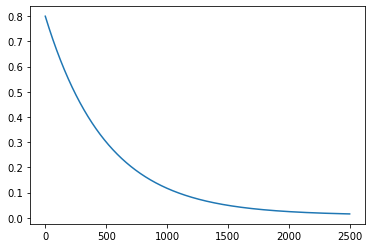

In [79]:
import math
import seaborn as sns
start_epsilon = 0.8
final_epsilon = 0.01
epsilon_decay_rate = 500

get_epsilon_value = lambda index: final_epsilon + (start_epsilon - final_epsilon) * math.exp(-1. * index / epsilon_decay_rate)

# Plotting decay graph
sns.lineplot(x = range(2500),y = [get_epsilon_value(i) for i in range(2500)])

### Main Sequential Driver function

In [186]:
def sequential_ddqn(env, num_episodes, discount_factor = 0.8, alpha = 0.1, eps = None):
    start_time = time.time()
    scores_window = deque(maxlen=100)
    completion_window = deque(maxlen=100)

    # Observation parameters
    observation_tree_depth = 2
    observation_radius = 10

    n_features_per_node = env.obs_builder.observation_dim
    n_nodes = 0
    for i in range(observation_tree_depth + 1):
        n_nodes += np.power(4, i)
    state_size = n_features_per_node * n_nodes
    
    target_network = Q_Network(state_size, env.action_space[0])
    memory = ReplayMemory(5000)
    
    agents = [Agent(state_size, memory) for i in range(num_agents)]
    
    scores = []
    completion = []
    action_count = [0] * action_size
    print('Training Sequentially')
    epsilons = np.logspace(np.log10(0.8), np.log10(0.1), num=num_episodes) if eps is None else eps
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        rewards = 0
        score = 0
        epsilon = get_epsilon_value(_)
        
        agent_current_observation = [None] * env.get_num_agents()
        agent_previous_observation = [None] * env.get_num_agents()
        agent_previous_action = [2] * env.get_num_agents()
        state_indexes = [None] * env.get_num_agents()
        action_thread = [None] * env.get_num_agents()

        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)
        for agent in env.get_agent_handles():
            if obs[agent]:
                agent_current_observation[agent] = normalize_observation(obs[agent], observation_tree_depth, observation_radius=observation_radius)
                agent_previous_observation[agent] = agent_current_observation[agent].copy()

        while True:
            steps += 1
            action_dict = {}
            queue = Queue()
            
            for agent in env.get_agent_handles():
                action = agents[agent].choose_action(agent_current_observation[agent], epsilon, queue)
                action_dict.update({agent: action})
                action_count[action] += 1

            next_state, reward, done, info = env.step(action_dict)
            
            for agent in env.get_agent_handles():
                if len(memory) > BATCH_SIZE:
                    agents[agent].step(agent_previous_observation[agent], agent_previous_action[agent], reward[agent], agent_current_observation[agent], done[agent], target_network)
                    agents[agent].learn(target_network)
                score += reward[agent]

                agent_previous_observation[agent] = agent_current_observation[agent].copy()
                agent_current_observation[agent] = normalize_observation(next_state[agent], observation_tree_depth, observation_radius=observation_radius)

            if done['__all__']:
                # Checking if all the agents have finished their episode
                break
            
        tasks_finished = np.sum([int(done[idx]) for idx in env.get_agent_handles()])
        completion_window.append(tasks_finished / max(1, env.get_num_agents()))
        scores_window.append(score / (max_steps * env.get_num_agents()))
        completion.append((np.mean(completion_window)))
        scores.append(np.mean(scores_window))
        action_probs = action_count / np.sum(action_count)

        
        end = " "

        print('\rTraining {} agents on {}x{}\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
            env.get_num_agents(),
            width, height,
            _,
            np.mean(scores_window),
            100 * np.mean(completion_window),
            epsilon,
            action_probs
        ), end=end)
    
    # Plotting results and completion
    plt.plot(scores)
    plt.show()

    plt.plot(completion)
    plt.show()

    print(f'Total time taken in sequential: {(time.time() - start_time)/1000} seconds')
    return agents, scores, (time.time() - start_time)/1000

### Main Parallel Driver function

In [169]:
def parallel_ddqn(env, num_episodes, discount_factor = 0.8, alpha = 0.1, eps = None):
    start_time = time.time()
    scores_window = deque(maxlen=100)
    completion_window = deque(maxlen=100)
    scores = []
    completion = []
    action_count = [0] * action_size

    # Observation parameters
    observation_tree_depth = 2
    observation_radius = 10

    n_features_per_node = env.obs_builder.observation_dim
    n_nodes = 0
    for i in range(observation_tree_depth + 1):
        n_nodes += np.power(4, i)
    state_size = n_features_per_node * n_nodes
    
    target_network = Q_Network(state_size, env.action_space[0])
    memory = ReplayMemory(5000)
    
    agents = [Agent(state_size, memory) for i in range(num_agents)]
    
    scores = []
    completion = []
    action_count = [0] * action_size
    
    epsilons = np.logspace(np.log10(0.8), np.log10(0.1), num=num_episodes) if eps is None else eps
    for _ in range(num_episodes):
        state = env.reset()
        done = False
        steps = 0
        rewards = 0
        score = 0
        epsilon = get_epsilon_value(_)
        
        agent_current_observation = [None] * env.get_num_agents()
        agent_previous_observation = [None] * env.get_num_agents()
        agent_previous_action = [2] * env.get_num_agents()
        state_indexes = [None] * env.get_num_agents()
        action_thread = [None] * env.get_num_agents()

        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)
        for agent in env.get_agent_handles():
            if obs[agent]:
                agent_current_observation[agent] = normalize_observation(obs[agent], observation_tree_depth, observation_radius=observation_radius)
                agent_previous_observation[agent] = agent_current_observation[agent].copy()

        while True:
            steps += 1
            action_dict = {}
            queue = Queue()
            for agent in env.get_agent_handles():
                thread = threading.Thread(target = agents[agent].choose_action, args = (agent_current_observation[agent], epsilon, queue))
                action_thread[agent] = thread
            for index, thread in enumerate(action_thread):
                thread.start()
                action = queue.get()
                action_dict.update({index: action})
                action_count[action] += 1
            for thread in action_thread:
                thread.join()

            next_state, reward, done, info = env.step(action_dict)
            
            learning_threads = []
            for agent in env.get_agent_handles():
                if len(memory) > BATCH_SIZE:
                    thread = threading.Thread(target = agents[agent].step, args = (agent_previous_observation[agent], agent_previous_action[agent], reward[agent], agent_obs[agent], done[agent], target_network,))
                    learning_threads.append(thread)
                    thread.start()
                score += reward[agent]

                agent_previous_observation[agent] = agent_current_observation[agent].copy()
                agent_current_observation[agent] = normalize_observation(next_state[agent], observation_tree_depth, observation_radius=observation_radius)
                
            if len(learning_threads) != 0:
                    [t.join() for t in learning_threads]
            if done['__all__']:
                # Checking if all the agents have finished their episode
                break
            
        # Collection information about training
        tasks_finished = np.sum([int(done[idx]) for idx in env.get_agent_handles()])
        completion_window.append(tasks_finished / max(1, env.get_num_agents()))
        scores_window.append(score / (max_steps * env.get_num_agents()))
        completion.append((np.mean(completion_window)))
        scores.append(np.mean(scores_window))
        action_probs = action_count / np.sum(action_count)

        
        end = " "

        print('\rTraining {} agents on {}x{}\t Episode {}\t Average Score: {:.3f}\tDones: {:.2f}%\tEpsilon: {:.2f} \t Action Probabilities: \t {}'.format(
            env.get_num_agents(),
            width, height,
            _,
            np.mean(scores_window),
            100 * np.mean(completion_window),
            epsilon,
            action_probs
        ), end=end)
    
    # Plotting results and completion
    plt.plot(scores)
    plt.show()

    plt.plot(completion)
    plt.show()

    print(f'Total time taken in Parallel: {(time.time() - start_time)/1000} seconds')
    return agents, scores, (time.time() - start_time)/1000

### Declaring parameters

In [170]:
MAX_CITIES = 2
SEED = 1
GRID_MODE = True
MAX_RAILS_BETWEEN_CITIES = 2
MAX_RAILS_IN_CITY = 1
PREDICTION_DEPTH = 150
WIDTH = 25
HEIGHT = 25
NUM_AGENTS = 2
MAX_RAILS = 100
MAX_STEPS = 200
REORDER_RAILS = True
LEARNING_RATE = 5e-5
BUFFER_SIZE = 10000
BATCH_SIZE = 512
NUM_EPISODES = 2500
CRASH_PENALTY = True
SWITCH2SWITCH = True
NETWORK_UPDATE_INTERVAL = 10
ACTION_SPACE = 2

### Running Tests

In [190]:
rail_generator = sparse_rail_generator(max_num_cities=MAX_CITIES,
                                       seed=SEED,
                                       grid_mode=GRID_MODE,
                                       max_rails_between_cities=MAX_RAILS_BETWEEN_CITIES,
                                       )
prediction_builder = ShortestPathPredictorForRailEnv(max_depth=PREDICTION_DEPTH)
obs_builder = CustomObservationBuilder(predictor=prediction_builder)
tree_observation = TreeObsForRailEnv(max_depth=2)
env = RailEnv(width=WIDTH,
              height=HEIGHT,
              rail_generator=rail_generator,
              random_seed=0,
              line_generator=sparse_line_generator(),
              number_of_agents=NUM_AGENTS,
              obs_builder_object=tree_observation,
              )

Training 2 agents on 24x24	 Episode 2499	 Average Score: -0.261	Dones: 100.00%	Epsilon: 0.10 	 Action Probabilities: 	 [0.08103426 0.29731993 0.11545883 0.0732215  0.43296548] 

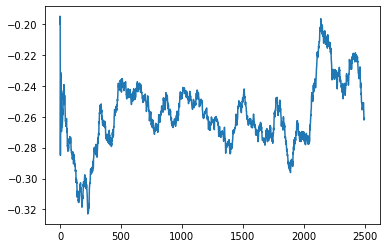

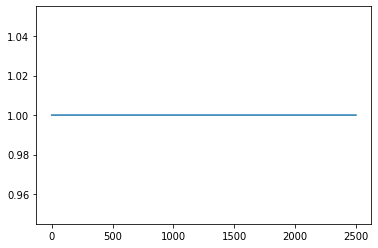

Total time taken: 0.5716303858757019 seconds


In [80]:
agents, scores, _ = parallel_ddqn(env, NUM_EPISODES)

Training 2 agents on 24x24	 Episode 4999	 Average Score: -0.258	Dones: 100.00%	Epsilon: 0.10 	 Action Probabilities: 	 [0.09718199 0.61861611 0.12453233 0.08087566 0.07879391] 

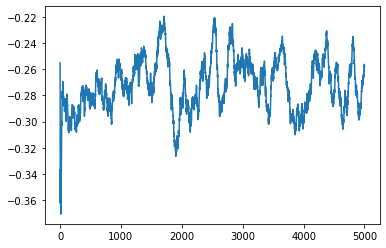

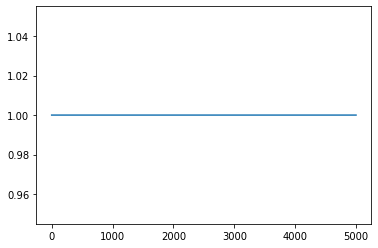

In [231]:
NUM_EPISODES = 5000
agents_seq, scores_seq, _ = sequential_ddqn(env, NUM_EPISODES)

# Working with A2C

## Sequential A2C

### Networks

In [174]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import gym
import pandas as pd
from flatland.envs.rail_env import RailEnv
# from utils import observation_utils 
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.line_generators import sparse_line_generator
from flatland.envs.observations import GlobalObsForRailEnv
# from utils.observation_utils import normalize_observation
from flatland.envs.observations import TreeObsForRailEnv
from torch.distributions import Categorical

In [175]:
#Defining the actor network
class Actor(nn.Module):
    def __init__(self,num_states,num_actions):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(num_states,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,num_actions)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out

#Defining the critic network
class Critic(nn.Module):

    def __init__(self,num_states):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(num_states,512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256,1)

    def forward(self,x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out


### Defining Agent

In [176]:
#Defining the agent class
class Agent:
    def __init__(self, env, num_states, num_actions):
        self.env = env
        # Defining networks and their optimizers
        self.actor_net = Actor(num_states, num_actions)
        self.critic_net = Critic(num_states)
    
        self.actor_net_optimizer = torch.optim.Adam(self.actor_net.parameters(),lr=LEARNING_RATE)
        self.critic_net_optimizer = torch.optim.Adam(self.critic_net.parameters(),lr=LEARNING_RATE)

    def choose_action(self, state):
        log_action_value = self.actor_net(Variable(torch.Tensor([state])))
        action_distribution = Categorical(log_action_value)
        action = action_distribution.sample()
        log_probs = action_distribution.log_prob(action)
        return action.item(), log_probs
    

    def learn(self, state, reward, next_state, done, log_probs):
        self.actor_net_optimizer.zero_grad()
        self.critic_net_optimizer.zero_grad()

        actor_next_value = self.actor_net(Variable(torch.Tensor([next_state])))
        critic_next_value = self.critic_net(Variable(torch.Tensor([next_state])))
        actor_value = self.actor_net(Variable(torch.Tensor([state])))
        critic_value = self.critic_net(Variable(torch.Tensor([state])))
        reward = torch.tensor(reward).float()

        td_error = reward + GAMMA * critic_next_value*(1-int(done)) - critic_value

        actor_loss = -log_probs * td_error
        critic_loss = td_error**2

        (actor_loss + critic_loss).backward()
        # critic_loss.backward(retain_graph=True)

        self.actor_net_optimizer.step()
        self.critic_net_optimizer.step()

### Main Driver function

In [179]:
#Main method incoporating the Actor Critic.
def sequential_a2c(env, obs_params, num_agents = 1):
    start_time = time.time()
    observation_tree_depth = obs_params['observation_tree_depth']
    observation_radius = obs_params['observation_radius']
    observation_max_path_depth = obs_params['observation_max_path_depth']
    
    scores_window = deque(maxlen=100)
    n_features_per_node = env.obs_builder.observation_dim
    n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
    state_size = n_features_per_node * n_nodes
    agents = [Agent(env, state_size, num_actions = env.action_space[0]) for i in range(num_agents)]
    score_history = []
    
    for i in range(NUM_EPISODES):
        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)
        done = False
        score = 0
        agent_obs = [0]*num_agents
        max_steps = env._max_episode_steps
        for step in range(max_steps):
            action_dict = {}
            prob_dict = {}
            for agent in env.get_agent_handles():
                if obs[agent]:
                    agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

                action = 0
                if info['action_required'][agent]:
                    action, prob_action = agents[agent].choose_action(agent_obs[agent])
                    action_dict.update({agent: action})
                    prob_dict.update({agent: prob_action})

            obs, all_rewards, done, info = env.step(action_dict)
            
            for agent in env.get_agent_handles():
                next_state = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
                agents[agent].learn(agent_obs[agent], all_rewards[agent], next_state, done[agent], prob_dict.get(agent, 0))
                score += all_rewards[agent]
            scores_window.append(score / (max_steps * env.get_num_agents()))

            if done['__all__']:
                break

        score_history.append(np.mean(scores_window))
        print(f'episode: {i} score: {score_history[-1]}')
    print(f'Total time taken in Parallel: {(time.time() - start_time)/1000} seconds')
    return agents, score_history, (time.time() - start_time)/1000

In [180]:
obs_params = {
    "observation_tree_depth": 2,
    "observation_radius": 10,
    "observation_max_path_depth": 30
}
WIDTH=25
HEIGHT=25
NUM_AGENTS = 2
LEARNING_RATE = 3e-4
NUM_EPISODES = 2500
GAMMA = 0.99

rail_generator = sparse_rail_generator(max_num_cities=2)
tree_observation = TreeObsForRailEnv(max_depth=2)

env = RailEnv(
        width=WIDTH,
        height=HEIGHT,
        rail_generator=sparse_rail_generator(
            max_num_cities=2,
            grid_mode=False,
            max_rails_between_cities=2,
            # max_rails_in_city=3
        ),
        # schedule_generator=sparse_schedule_generator(),
        number_of_agents=NUM_AGENTS,
        obs_builder_object=tree_observation
    )

agent_seq_a2c, scores_seq_a2c, _ = sequential_a2c(env, obs_params, NUM_AGENTS)

episode: 0 score: -0.012110726643598616
episode: 1 score: -0.011521298174442189
episode: 2 score: -0.010344827586206895
episode: 3 score: -0.012254901960784315
episode: 4 score: -0.017254901960784316
episode: 5 score: -0.03573316283034953
episode: 6 score: -0.03404429860541427
episode: 7 score: -0.028456063311296624
episode: 8 score: -0.015958194598594155
episode: 9 score: -0.01742269984917044
episode: 10 score: -0.021531593406593403
episode: 11 score: -0.015513014527845037
episode: 12 score: -0.0085006518904824
episode: 13 score: -0.01353988603988604
episode: 14 score: -0.02053988603988604
episode: 15 score: -0.025796296296296296
episode: 16 score: -0.013148148148148148
episode: 17 score: -0.029669887278582933
episode: 18 score: -0.030503220611916265
episode: 19 score: -0.03550322061191626
episode: 20 score: -0.027523148148148147
episode: 21 score: -0.023245370370370368
episode: 22 score: -0.009199233716475096
episode: 23 score: -0.015224874742116121
episode: 24 score: -0.015662072809

NameError: name 'scores' is not defined

## Parallel A2C

In [184]:
#Main method incoporating the Actor Critic.
def parallel_a2c(env, obs_params, num_agents = 1):
    start_time = time.time()
    observation_tree_depth = obs_params['observation_tree_depth']
    observation_radius = obs_params['observation_radius']
    observation_max_path_depth = obs_params['observation_max_path_depth']
    
    scores_window = deque(maxlen=100)
    n_features_per_node = env.obs_builder.observation_dim
    n_nodes = sum([np.power(4, i) for i in range(observation_tree_depth + 1)])
    state_size = n_features_per_node * n_nodes
    agents = [Agent(env, state_size, num_actions = env.action_space[0]) for i in range(num_agents)]
    score_history = []
    
    for i in range(NUM_EPISODES):
        obs, info = env.reset(regenerate_rail=True, regenerate_schedule=True)
        done = False
        score = 0
        agent_obs = [0]*num_agents
        max_steps = env._max_episode_steps
        for step in range(max_steps):
            action_dict = {}
            prob_dict = {}
            for agent in env.get_agent_handles():
                if obs[agent]:
                    agent_obs[agent] = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)

                action = 0
                if info['action_required'][agent]:
                    action, prob_action = agents[agent].choose_action(agent_obs[agent])
                    action_dict.update({agent: action})
                    prob_dict.update({agent: prob_action})

            obs, all_rewards, done, info = env.step(action_dict)
            learning_thread = []
            for agent in env.get_agent_handles():
                next_state = normalize_observation(obs[agent], tree_depth=observation_tree_depth, observation_radius=observation_radius)
                thread = threading.Thread(target = agents[agent].learn, args=(agent_obs[agent], all_rewards[agent], next_state, done[agent], prob_dict.get(agent, 0),))
                learning_thread.append(thread)
                thread.start()
                score += all_rewards[agent]
            if len(learning_thread) != 0:
                [t.join() for t in learning_thread]
            scores_window.append(score / (max_steps * env.get_num_agents()))

            if done['__all__']:
                break
        
        score_history.append(np.mean(scores_window))
        print(f'episode: {i} score: {score_history[-1]}')
    print(f'Total time taken in Parallel: {(time.time() - start_time)/1000} seconds')
    return agents, score_history, (time.time() - start_time)/1000

In [17]:
obs_params = {
    "observation_tree_depth": 2,
    "observation_radius": 10,
    "observation_max_path_depth": 30
}
WIDTH=25
HEIGHT=25
NUM_AGENTS = 2
LEARNING_RATE = 3e-4
NUM_EPISODES = 2500
GAMMA = 0.99

rail_generator = sparse_rail_generator(max_num_cities=2)
tree_observation = TreeObsForRailEnv(max_depth=2)

env = RailEnv(
        width=WIDTH,
        height=HEIGHT,
        rail_generator=sparse_rail_generator(
            max_num_cities=2,
            grid_mode=False,
            max_rails_between_cities=2,
            # max_rails_in_city=3
        ),
        # schedule_generator=sparse_schedule_generator(),
        number_of_agents=NUM_AGENTS,
        obs_builder_object=tree_observation
    )

agent_parallel_a2c, scores_parallel_a2c, _ = parallel_a2c(env, obs_params, NUM_AGENTS)

episode: 0 score: -0.018853305785123967
episode: 1 score: -0.018060064935064936
episode: 2 score: -0.0213243006993007
episode: 3 score: -0.011238591916558018
episode: 4 score: -0.011238591916558018
episode: 5 score: -0.011381042059008162
episode: 6 score: -0.01077905491698595
episode: 7 score: -0.009036330049261083
episode: 8 score: -0.006553571428571429
episode: 9 score: -0.013220238095238096
episode: 10 score: -0.012903954802259887
episode: 11 score: -0.009773002421307506
episode: 12 score: -0.010687229437229438
episode: 13 score: -0.015020562770562771
episode: 14 score: -0.013839687194525906
episode: 15 score: -0.023688172043010755
episode: 16 score: -0.02685483870967742
episode: 17 score: -0.012583333333333334
episode: 18 score: -0.009369047619047619
episode: 19 score: -0.013303571428571428
episode: 20 score: -0.017918956043956043
episode: 21 score: -0.01763324175824176
episode: 22 score: -0.015282051282051281
episode: 23 score: -0.01492896174863388
episode: 24 score: -0.0102197418

NameError: name 'scores' is not defined

# Comparing Results of Sequential vs Parallel

### DDQN

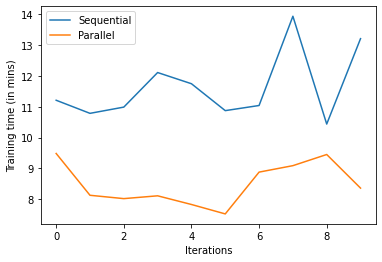

In [5]:
sequential_time_ddqn = []
parallel_time_ddqn = []
for i in range(10):
    start = time.time()
    sequential_ddqn(env, NUM_EPISODES)
    sequential_time_ddqn.append((time.time() - start_time)/1000)
    start = time.time()
    parallel_ddqn(env, NUM_EPISODES)
    parallel_time_ddqn.append((time.time() - start_time)/1000)
    
plt.plot(seq_time, label="Sequential")
plt.plot(parallel_time, label="Parallel")
plt.xlabel("Iterations")
plt.ylabel("Training time (in mins)")
plt.legend()
plt.show()

### A2C

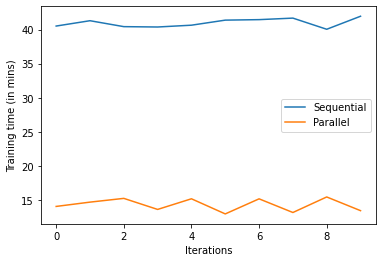

In [4]:
sequential_time_a2c = []
parallel_time_a2c = []
for i in range(10):
    start = time.time()
    sequential_ddqn(env, NUM_EPISODES)
    sequential_a2c.append((time.time() - start_time)/1000)
    start = time.time()
    parallel_a2c(env, NUM_EPISODES)
    parallel_time_a2c.append((time.time() - start_time)/1000)
plt.plot(seq_time, label="Sequential")
plt.plot(parallel_time, label="Parallel")
plt.xlabel("Iterations")
plt.ylabel("Training time (in mins)")
plt.legend()
plt.show()

# Comparing Results of DDQN vs A2C (Sequential)

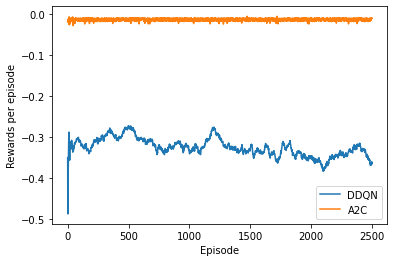

In [103]:
plt.plot(scores, label="DDQN")
plt.plot(scores_seq_a2c, label="A2C")
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Rewards per episode')
plt.show()

# Conclusions:
There are two main conclusions which can be drawn from our project:
<ol><li> DDQN trains faster than A2C algorithm for the same hyper parameters</li>
    <li> A2C gives better rewards as compared to DDQN for the same hyper parameters</li>
    <li> In the case of DDQN, there is not much of a difference between Sequential and Parallel learning. However, in the case of A2C, we can see that there is a huge gap in the computation time of Sequential vs Parallel.
    </ol>

### References:
<ul>
    <li>https://www.aicrowd.com/showcase/observing-the-flatland-3-environment</li>
    <li>https://flatland.aicrowd.com/getting-started/sequential-agent.html</li>
    <li>https://www.aicrowd.com/challenges/flatland-3/submissions</li>